# Text Preprocessing

Last updated: 09202023  
By: Lauren Liao, Pratik Sachdeva  
Purpose: data cleaning with basic summaries

In [4]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
import wordninja

from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams
from collections import Counter
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS, Phraser
from nltk.corpus import words
from tqdm import tqdm

import spacy
from nltk.corpus import wordnet

**Constants and functions**

VALID_WORDS: words that are in the nltk corpus  
VALID_WORDS2: words in the wordnet nltk corpus  

_americanize_ converts English spellings to American English  
_proprocess_ removes punctuations and other miscellaneous steps to make the text more uniform  
_clean_underline_words_ cleans the underline words including any misspellings  
_token_preprocess_ prepocess the words more individually as tokens

In [2]:
# VALID_WORDS is specified separately as VALID_WORDS2 has more words

VALID_WORDS = words.words()
VALID_WORDS.append('bame')
VALID_WORDS.append('coronavirus')
VALID_WORDS.append('disadvantaged')
VALID_WORDS = [word.lower() for word in VALID_WORDS if len(word) > 1]
VALID_WORDS2 = list(wordnet.words())

In [3]:
"ba" in VALID_WORDS

True

In [3]:
# Convert British English spellings to American English
def americanize(string):
    url = "https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
    british_to_american_dict = requests.get(url).json()    

    for british_spelling, american_spelling in british_to_american_dict.items():
        string = string.replace(british_spelling, american_spelling)
  
    return string

In [4]:
def preprocess(text):
    """Preprocesses text from pd.series"""
    
    # word break
    word_break_pattern = r"\b(\w+)\-?\n?(\w+)\b"
    text = text.apply(lambda x: re.sub(word_break_pattern, r"\1\2", x, flags=re.MULTILINE))
    
    # DOI 
    doi_pattern = r'\b10\.\d{4,9}/[-.;()/:\w]+'
    doi_repl = ''
    text = text.str.replace(doi_pattern, doi_repl, regex=True)

    # URL 
    url_pattern = r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'
    url_repl = ''
    text = text.str.replace(url_pattern, url_repl, regex=True)

    # digit
    # remove them
    digit_pattern = '\d+'
    digit_repl = ''
    text = text.str.replace(digit_pattern, digit_repl, regex=True)
    
    # Lowercase
    text = text.str.lower()
    # Apostrophes
    text = text.str.replace('[’+]', '', regex=True)
    # Hyphens
    text = text.str.replace('[-]', '', regex=True)
    # Replace punctuation with space
    text = text.str.replace('[^\w\s]', ' ', regex=True)
    # Remove new lines
    text = text.str.replace('\n', ' ', regex=True)
    
    text = text.apply(lambda x: americanize(x))
    text = text.str.replace('diskrimination', 'discrimination') # Fixing an typo in the json file
    text = text.str.replace('diskourse', 'discourse') # Fixing an typo in the json file
    text = text.str.replace('transmision', 'transmission') # Fixing an typo in the json file
    text = text.str.replace(' dis ', '')
    
    # Remove blank spaces
    blankspace_pattern = r'\s+'
    blankspace_repl = ' '
    text = text.str.replace(blankspace_pattern, blankspace_repl, regex=True)
    text = text.str.strip()
    
    return(text)

In [5]:
replacements = {"eff_ect": "effect", "diff_e_rent": "different", "le_likely": "likely",
                "black_m": "black", "th_century": "century", "disk_ri_minatory": "discriminatory",
                "c_ovid": "covid", "syn_demi_c": "syndemic", "fi_rst": "first", "bene_fi": "benefit",
                "adopt_ee": "adoptee", "diff_e_rence": "difference", "disk_ip_line": "discipline",
                "disk_u_sion": "discussion", "disk_u_sed": "discussed", "ff_ect": "effect",
                "eff_t": "effect", "disk_lo_sure": "disclosure",
                "diff_cult": "difficult", "fi_n_ding": "finding",
                "fi_nanci_al": "financial",
                "eff_ect_ive": "effective",
                "sars_cov": "sars_cov2",
                "detain_ee": "detainee",
                "multi_sector_al": "multisectoral",
                "peri_natal": "perinatal",
                "com_bidi_tie": "comorbidity",
                "prior_iz_ation": "prioritization",
                "disk_rim_ate": "discriminate",
                "perspective_www_lancet_com": "perspective",
                "protected_copyright_bmj": "protected",
                "br_exit": "brexit",
                "told_bmj": "told",
                "nh_england": "england",
                "st_century": "century",
                "ff_ec_ted": "effected",
                "sign_cant_ly": "significantly",
                "disk_u_sing": "discussing",
                "scientifi_c": "scientific",
                "diff_cul_tie": "difficulty",
                "fi_nd": "find",
                "appendix_p": "appendix",
                "intersection_ali_ty": "intersectionality",
                "bio_logic": "biologic",
                "diff_er": "differ",
                "fl_u": "flu",
                "su_ff_e_ring": "suffering",
                "def_n_ion": "definition",
                "con_founder": "confounder",
                "ref_l_ect": "reflect",
                "eff_ort": "effort",
                "p_harm_co_logical": "pharmacological",
                "sign_cant": "significant",
                "disk_om_fort": "discomfort",
                "ident_cation": "identification",
                "fi_lm": "film",
                "intersection_al": "intersectional",
                "un_adjusted": "unadjusted",
                "un_met": "unmet",
                "disk_tio_nary": "dictionary",
                "disk_us": "discuss",
                "co_payment": "copayment",
                "epi_de_mio_logi": "epidemiology",
                "co_nfl_ict": "conflict",
                "enroll_l_ment": "enrollment",
                "md_g_target": "target",
                "minor_ed": "minored",
                "stigma_ti_z_ation": "stigmatization",
                "med_line": "medline",
                "ha_emo_dynamic": "haemodynamic",
                "lef_fall": "fall",
                "eff_ect_ive_ness": "effectiveness",
                "sector_al": "sectoral",
                "peri_natal_mortality": "perinatal_mortality",
                "fl_ow": "flow",
                "fulfill_l": "fulfill",
                "wels_ing": "welsing",
                "disk_har_ged": "discharged",
                "disk_lose": "disclose",
                "eff_ect_iv_ely": "effectively",
                "fi_nanci": "financial",
                "appall_ling": "appalling",
                "car_dio": "cardio",
                "lgbt_q": "lgbtq",
                "km_iet_owicz": "kmietowicz",
                "gestation_al": "gestational",
                "exclusion_ary": "exclusionary",
                "uni_variate": "univariate",
                "mr_chau_dha_ry": "mr_chaudhary",
                "lund_berg": "lundberg",
                "mc_score": "score",
                "co_variate": "covariate",
                "bidi_l": "bidil",
                "disk_rete": "discrete",
                "cha_nag_paul": "chanagpaul",
                "plunk_et": "plunket",
                "ff_ec_ting": "effecting",
                "atri_cul": "articul",
                "ap_ea": "apea",
                "g_astro": "gastro",
                "giridhara_da": "giridharadas",
                "cadaver_ic": "cadaveric",
                "pro_actively": "proactively",
                "cor_tico_steroid": "corticosteroid",
                "comp_licit": "complicit",
                "du_ally": "dually",
                "enroll_l": "enroll",
                "dia_logic": "dialogic"
               }
removals = ["et_al", "md_g", 
            "n_engl_j_med", "medicine_downloaded_ne_j",
            "spec_c", "disk_us_ion", "copyright_massachusetts_medical", "association_right_reserved",
            "h_ic", "nh_trust", "ne_j_org", "sd_g", "org_depaul_university_march",
            "lm_ic", "def_ned", "iz_ation", "e_g", "downloaded_depaul_university_pre",
            "ch_w", "ident_ed",  "n_cd", "disk_ed", "fi_el", "en_ce", "bmj_com",
            "e_gfr", "rm_n_cah", "fl_exner", "ori_non_pac_c", "blu_men_bach", "used_uk_cat",
            "ey_w", "bmj_bmj_doi", "suf_fi", "na_em", "fi_cia_l", "md_mph",
            "e_cozy_stem", "ischemic_heart", "cite_bmj", "fi_gu", "u_without_permission_copyright_massachusetts",
            "def_ne", "cie_nt", "p_h", "pac_c", "b_awa_garb", "ori_non", "de_bow_ale", "hall_ig", "p_harm",
            "full_story_doi", "w_re", "appendix_pp", "ne_j_org_november", "p_harm_co",
            "fi_ed",
            "h_arge",
            "comment_www_lancet_com",
            "ac_uk",
            "disk_rep",
            "disk_rim_ted", "jama_network_open", "uh_c", 
            "see_supplementary", "use_u_without_permission", "rc_gp", "ka_er", 
            "ne_j_org_september",
            "reprinted_jama",
            "edu_opinion_jama_com",
            "zur_cruz",
            "disk_y",
            "subscribe_l_doi_published",
            "bmj_doi",
            "eff_cie",
            "disk_ip",
            "colo_gist",
            "doi_pmid",
            "rr_ci",
            "caput_tion",
            "lo_cum",
            "cb_pr",
            "ph_o",
            "spec_call",
            "disk_rim",
            "te_ques",
            "www_lancet_com_vol",
            "disk_nec",
            "ne_phr",
            "king_fund",
            "http_www",
            "ali_ty",
            "jama_com_reprinted_jama",
            "la_cell",
            "su_ff",
            "fi_ce",
            "cpp_r",
            "aldo_ster",
            "ey_w_copyright",
            "ff_able",
            "ful_fi",
            "thro_po",
            "gl_omer",
            "rim_mer",
            "rd_ci",
            "logi_st",
            "pre_ey",
            "com_reprinted_jama",
            "cia_l",
            "pac_c_people",
            "chau_dha",
            "org_june",
            "copyright_bmj_first",
            "ref_l",
            "ne_j_org_july",
            "march_personal",
            "lancet_com",
            "e_ring",
            "co_nfl",
            "demi_c",
            "iv_ely",
            "diff_e",
            "cd_cell",
            "ec_ted",
            "co_bucci",
            "disk_har",
            "disk_ipl",
            "ary_team",
            "lynch_et_al"
           ]

def clean_underline_words(sentences, replacements=replacements, removals=removals):
    clean_sentences = [[replacements.get(item, item) for item in sentence] for sentence in sentences]
    return [[item for item in clean_sentence if item not in removals] for clean_sentence in clean_sentences]

In [6]:
def token_preprocess(text, return_excluded=False):
    """Preprocesses text from pd.series"""
    sentences = text.to_list()
    sentences = [nltk.word_tokenize(s) for s in sentences]
    stop = stopwords.words('english')
    stop.append('also')
    stop.append('eg')
    stop.append('aliz')
    stop.append('mi')
    
    lemmatizer = WordNetLemmatizer()
    # following: [[float(y) for y in x] for x in l] syntax
    sentences = [[lemmatizer.lemmatize(token) for token in s if token not in stop] for s in sentences]
    
    ## using word ninja
    ## added bame into the special words to not split by wordninja
    split_sentences = [[wordninja.split(token) if (token != "covid" and token != "bame") else [token] for token in s] for s in sentences]
    # flatten this 
    split_sentences = [[token for s in sublist for token in s] for sublist in split_sentences]

    # do this again for split_sentences
    split_sentences = [[lemmatizer.lemmatize(token) for token in s if token not in stop] for s in split_sentences]
    
    bigram = Phrases(split_sentences, min_count=10, threshold=100, connector_words=ENGLISH_CONNECTOR_WORDS)
    trigram = Phrases(bigram[split_sentences], min_count=10, threshold=50, connector_words=ENGLISH_CONNECTOR_WORDS)
    
    bigram_phraser = Phraser(bigram)
    trigram_phraser = Phraser(trigram)
    processed_sentences = [trigram_phraser[bigram_phraser[s]] for s in split_sentences]
    
    clean_underline_sentences = clean_underline_words(processed_sentences)
        
    # add to check what is valid
    processed_sentences_new = [[word 
                if (word in VALID_WORDS) | ("_" in word) 
                else word
                if (word in ["psa", "usa", "adhd", "usda", "asia", "paid", "tzar"]) | (len(word) > 4 and word in VALID_WORDS2)  
                else "" for word in s] for s in tqdm(clean_underline_sentences)]

    processed_sentences_new = [[word for word in s if len(word) > 0] for s in tqdm(processed_sentences_new)]
    

    if(return_excluded):
        # take the difference for pairwise comparison for each article
        def get_unique_excluded(list1, list2):
            unique_words = set()

            for sublist1, sublist2 in zip(list1, list2):
                set1 = set(sublist1)
                set2 = set(sublist2)
                unique_words.update(set1 - set2)

            return list(unique_words)
        excluded_words = get_unique_excluded(clean_underline_sentences, processed_sentences_new)
        return(processed_sentences_new, excluded_words)
    
    return(processed_sentences_new)

**Data loading**  
reading data requires openpyxl download separately as well

In [7]:
path = '../data/full_data.xlsx'
data = pd.read_excel(path)

## Data preprocessing step 1: uniform text cleaning
data preprocessing steps as outlined here:  
(1) merging multiple texts into a single column  
(2) find and replace word break patterns residue from pdf  
(3) replace doi, url, digit with respective pattern recognizers  
(4) standardize to lower case then removing apostrophes, hypens, punctuations, new lines  
(5) standardize to American English  
(6) correct misspellings

In [8]:
# Grab text columns
text_cols = data.filter(regex='^full_text')
# Merge text columns into a single column
data['full_text'] = text_cols.apply(
    lambda x: ' '.join(x.dropna()),
    axis=1)

In [9]:
%%time
data['text'] = preprocess(data['full_text'])

CPU times: user 1min 35s, sys: 1.64 s, total: 1min 37s
Wall time: 2min 7s


## Data preprocessing step 2: Tokenizing and preprocess tokenized text
create sentences and tokenize each word to vectorize the words to see what is most similar  
"sentences" here refers to the full text for the separate texts  
processing (tokenizing) is done to  
(1) remove stop words and words shouldn't be split  
(2) lemmatize the tokens   
(3) split the connected words using wordninja   
(4) merge bigrams or trigrams  
(5) check the word if it is valid from VALID_WORD or has underscore otherwise check if the word is in a specific list or (it is more than 4 letter and in the VALID_WORD2 corpus)  
(6) clean the underline words and fix misspellings
(7) return excluded words if desired

In [10]:
%%time
data['processed_text'], excluded_words = token_preprocess(data['text'], return_excluded=True)

100%|███████████████████████████████████████| 870/870 [00:00<00:00, 7824.52it/s]


CPU times: user 17min 10s, sys: 3.95 s, total: 17min 14s
Wall time: 17min 14s


In [11]:
data.to_pickle('../data/full_data_w_processedtext.pkl')

### Initial summary

In [5]:
# read processed text from previous
full_text = pd.read_pickle('../data/full_data_w_processedtext.pkl')
processed_text = full_text['processed_text'] 

In [6]:
# only working with the this particular column moving forward
sentences = [x for x in processed_text]

In [15]:
all_text_tokens = [item for sublist in sentences for item in sublist]

token_counts = Counter(all_text_tokens)
top_20_tokens = token_counts.most_common(20)
print([x for x,y in top_20_tokens])

bigram_trigram_tokens = [token for token in all_text_tokens if "_" in token]
multi_token_counts = Counter(bigram_trigram_tokens)
top_20_multi_tokens = multi_token_counts.most_common(20)
print([x for x,y in top_20_multi_tokens])

['health', 'patient', 'people', 'care', 'medical', 'black', 'population', 'social', 'community', 'one', 'group', 'country', 'service', 'woman', 'many', 'study', 'system', 'doctor', 'need', 'public']
['ethnic_minority', 'medical_school', 'african_american', 'united_state', 'human_right', 'risk_factor', 'blood_pressure', 'structural_racism', 'ethnic_group', 'racial_ethnic', 'social_determinant', 'long_term', 'south_asian', 'life_expectancy', 'primary_care', 'race_ethnicity', 'new_zealand', 'heart_disease', 'hiv_infection', 'year_old']


#### Lollipop graph function

In [67]:
def lolli_graph(tuple_tokens_list, 
                title='Most common words in the corpus',
                line_color='skyblue',
                point_color='steelblue'
               ):
    top_20_tokens_sorted = sorted(tuple_tokens_list, key=lambda x: x[1])
    top_20_words, top_20_counts = zip(*top_20_tokens_sorted)
    plt.hlines(y=top_20_words, 
               xmin=0, xmax=top_20_counts, color=line_color, linewidth=3)
    plt.plot(top_20_counts, top_20_words, "o", color=point_color)

    plt.ylabel('Words', fontsize=14)
    plt.xlabel('Frequency', fontsize=14)
    plt.title(title, fontsize=16)

    plt.show()

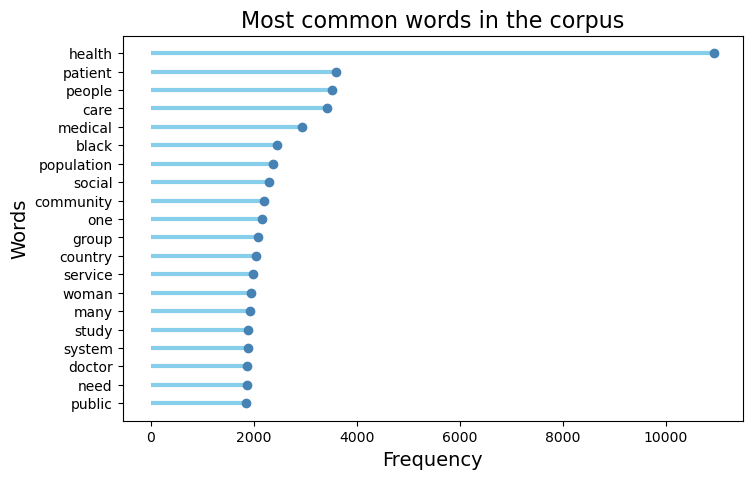

In [69]:
plt.figure(figsize=(8, 5)) 
lolli_graph(top_20_tokens)

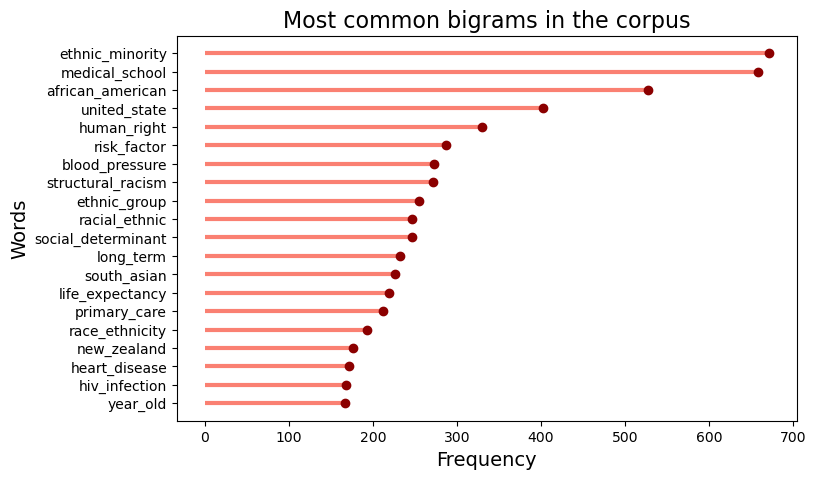

In [70]:
plt.figure(figsize=(8, 5)) 
lolli_graph(top_20_multi_tokens, 
            title='Most common bigrams in the corpus',
            line_color='salmon', point_color='darkred')

In [57]:
KEYTERMS2 = ['health', 'patient', 'doctor', 'resource', 'class', 
            'care', 'medical',
            'population', 'social', 'community', 'system',
            'race', 'black', 'white', 'bame', 'minority', 
            'racism', 'disadvantaged',
            'discrimination', 'wealth', 'poverty', 'power', 'bias', 'structural', 
            'ethnic_minority', 'african_american', 'human_right', 'risk_factor',
            'structural_racism', 'racial_ethnic', 'social_determinant', 'life_expectancy']

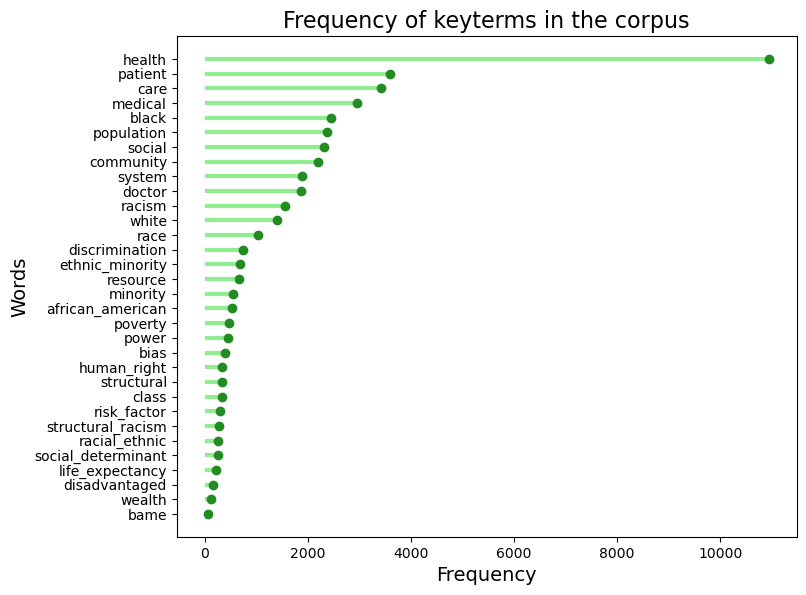

In [81]:
keyterm_count_tokens = [(key, token_counts[key]) for key in KEYTERMS2]
plt.figure(figsize=(8, 6.5)) 
lolli_graph(keyterm_count_tokens, 
            title='Frequency of keyterms in the corpus',
            line_color='lightgreen', point_color='forestgreen')